# |In this notebook we apply our SEIR model to the US Covid-19 data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import lmfit

In [2]:
sns.set()
%matplotlib inline

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
from sir_models.seir import SEIR

# Load data

In [57]:
df = pd.read_csv('data/United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv', sep=',')

In [58]:
df.head()

,submission_date,state,tot_cases,conf_cases,prob_cases,new_case,pnew_case,tot_death,conf_death,prob_death,new_death,pnew_death,created_at,consent_cases,consent_deaths
0,05/04/2020,KY,5245,5245.0,0.0,115,0.0,261,261.0,0.0,8,0.0,05/05/2020 05:25:08 PM,Agree,Agree
1,12/08/2020,OK,205999,171497.0,34502.0,0,0.0,1752,1680.0,72.0,0,0.0,12/09/2020 02:45:40 PM,Agree,Agree
2,08/21/2020,MD,103523,NaN,NaN,624,0.0,3685,3546.0,139.0,11,1.0,08/22/2020 02:21:09 PM,NaN,Agree
3,04/01/2020,MN,742,NaN,NaN,53,NaN,18,NaN,NaN,1,NaN,03/31/2020 04:22:39 PM,NaN,Agree
4,06/25/2020,NE,18346,NaN,NaN,125,0.0,260,NaN,NaN,3,0.0,06/26/2020 07:18:27 PM,Not agree,Not agree


In [59]:
df['date'] = pd.to_datetime(df['submission_date'], format='%m/%d/%Y')

df['total_infected'] = df['tot_cases']
df['infected_per_day'] = df['new_case'] 
df['total_dead'] = df['tot_death']
df['dead_per_day'] = df['new_death']
#df['total_recovered'] = df['total_infected'] - df['total_dead']

#df['infected'] = df['total_infected'] - df['total_recovered'] - df['total_dead']

df = df[['state', 'date', 'total_infected', 'infected_per_day', 'total_dead', 'dead_per_day']]

In [60]:
df.head()

,state,date,total_infected,infected_per_day,total_dead,dead_per_day
0,KY,2020-05-04,5245,115,261,8
1,OK,2020-12-08,205999,0,1752,0
2,MD,2020-08-21,103523,624,3685,11
3,MN,2020-04-01,742,53,18,1
4,NE,2020-06-25,18346,125,260,3


In [61]:
df = df.sort_values(by='date')
df = df[df.state == 'NY'].reset_index(drop=True)
df.index = df.date
#df = df.groupby('date').sum().reset_index()

In [62]:
df.head()

,state,date,total_infected,infected_per_day,total_dead,dead_per_day
date,,,,,,
2020-01-22,NY,2020-01-22,0,0,0,0
2020-01-23,NY,2020-01-23,0,0,0,0
2020-01-24,NY,2020-01-24,0,0,0,0
2020-01-25,NY,2020-01-25,0,0,0,0
2020-01-26,NY,2020-01-26,0,0,0,0


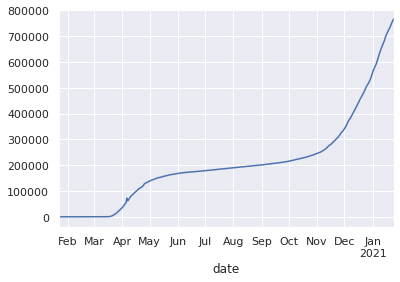

In [63]:
df['total_infected'].plot()

In [65]:
df_smoothed = df.drop(columns=['state']).rolling(7).mean()
df_smoothed['date'] = df['date']
df_smoothed.head(10)

,total_infected,infected_per_day,total_dead,dead_per_day,date
date,,,,,
2020-01-22,NaN,NaN,NaN,NaN,2020-01-22
2020-01-23,NaN,NaN,NaN,NaN,2020-01-23
2020-01-24,NaN,NaN,NaN,NaN,2020-01-24
2020-01-25,NaN,NaN,NaN,NaN,2020-01-25
2020-01-26,NaN,NaN,NaN,NaN,2020-01-26
2020-01-27,NaN,NaN,NaN,NaN,2020-01-27
2020-01-28,0.0,0.0,0.0,0.0,2020-01-28
2020-01-29,0.0,0.0,0.0,0.0,2020-01-29
2020-01-30,0.0,0.0,0.0,0.0,2020-01-30


Text(0.5, 1.0, 'Total infected smoothed')

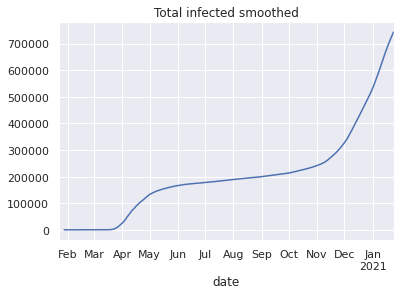

In [68]:
df_smoothed.total_infected.plot()
plt.title('Total infected smoothed')

Text(0.5, 1.0, 'Total dead')

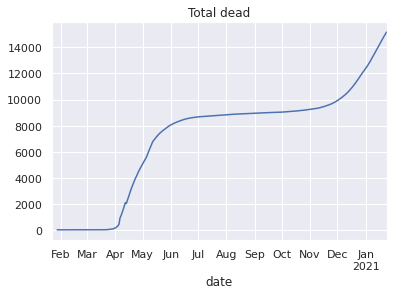

In [69]:
df_smoothed.total_dead.plot()
plt.title('Total dead')

In [70]:
df = df_smoothed.dropna().reset_index(drop=True)

### Modelling infection fear and quarantine measures

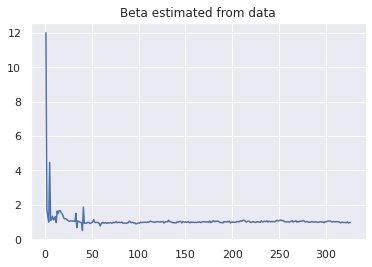

In [84]:
beta_from_data = (df['total_infected'].diff() / df['total_infected'].diff().shift(1)).dropna().values
plt.plot(beta_from_data)
plt.title('Beta estimated from data')
plt.show()

In [86]:
beta_base = beta_from_data[20:].max()
beta_base

1.8719267436026013

Text(0.5, 1.0, 'Infection "fear"')

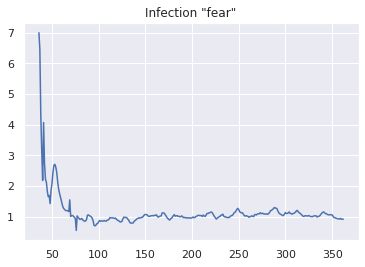

In [88]:
fear = df['infected_per_day']/df['infected_per_day'].rolling(7).mean()
plt.plot(fear)
plt.title('Infection "fear"')

[]

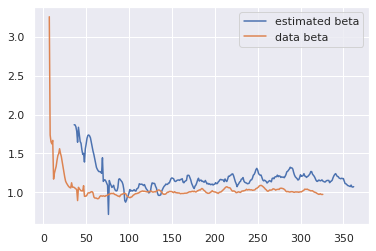

In [94]:
beta_fear = beta_base - 2 * 1/np.exp(fear)
plt.plot(beta_fear, label='estimated beta')
pd.Series(beta_from_data).rolling(7).mean().plot(label='data beta')
plt.legend()
plt.plot()

In [96]:
beta_fear

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
358    1.073818
359    1.092758
360    1.069515
361    1.067374
362    1.072204
Name: infected_per_day, Length: 363, dtype: float64

In [98]:
beta_fear[200], beta_from_data[200]

(1.1044505543266299, 0.9946168461051758)

# Set global params

In [100]:
population = 8_336_817

# SIR first peak

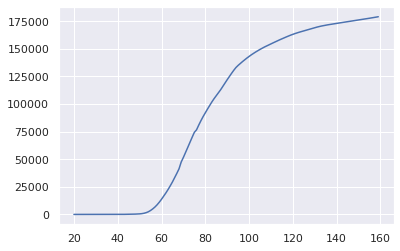

In [102]:
df[20:160]['total_infected'].plot()

In [106]:
df.iloc[50]

total_infected                  495.429
infected_per_day                125.571
total_dead                     0.571429
dead_per_day                   0.142857
date                2020-03-18 00:00:00
Name: 50, dtype: object

In [112]:
model = SEIR(population)

subset = df[50:160]
model.fit(subset)

result = model.fit_result_
#result.plot_fit(datafmt="-");
result

In [113]:
R0 = result.params['beta']/result.params['gamma']
R0

2.85

In [114]:
S, E, I, R, D = model.predict_train()

In [115]:
R[0], E[0], I[0], D[0]

(45.941520467836256, 0.0, 444.44444444444446, 0.5714285714285714)

In [116]:
subset.iloc[0]

total_infected                  495.429
infected_per_day                125.571
total_dead                     0.571429
dead_per_day                   0.142857
date                2020-03-18 00:00:00
Name: 50, dtype: object

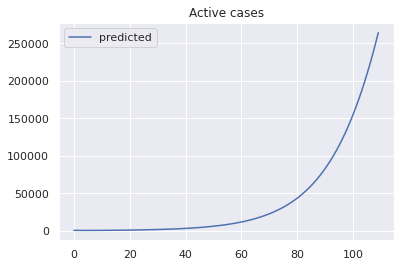

In [118]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, I, label='predicted')
plt.legend()
plt.title('Active cases')
plt.show()

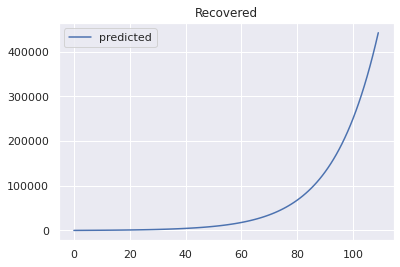

In [120]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, R, label='predicted')
plt.legend()
plt.title('Recovered')
plt.show()

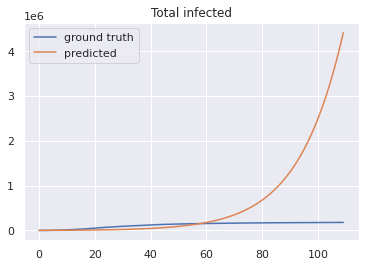

In [121]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['total_infected'], label='ground truth')
plt.plot(x, I.cumsum(), label='predicted')
plt.legend()
plt.title('Total infected')
plt.show()

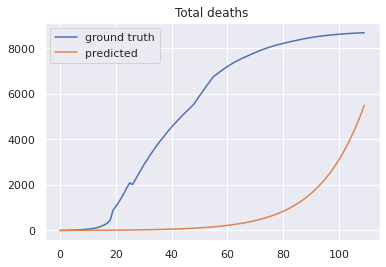

In [122]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['total_dead'], label='ground truth')
plt.plot(x, D, label='predicted')
plt.legend()
plt.title('Total deaths')
plt.show()

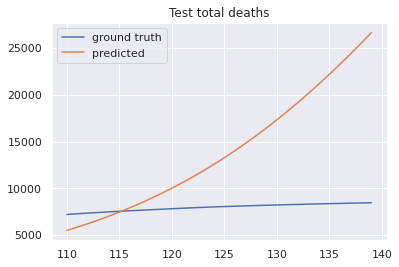

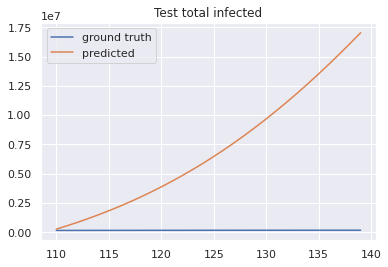

In [123]:
test_subset = df[len(subset):len(subset)+30]

test_t = np.arange(len(subset), len(subset)+len(test_subset))
S, E, I, R, D = model.predict_test(test_t)

plt.figure()
plt.plot(test_t, test_subset['total_dead'], label='ground truth')
plt.plot(test_t, D, label='predicted')
plt.legend()
plt.title('Test total deaths')
plt.show()

plt.figure()
plt.plot(test_t, test_subset['total_infected'], label='ground truth')
plt.plot(test_t, I.cumsum(), label='predicted')
plt.legend()
plt.title('Test total infected')
plt.show()


# SEIR full

In [160]:
model = SEIR(population)
subset = df[200:]
model.fit(subset)

S, E, I, R, D = model.predict_train()

result = model.fit_result_
R0 = result.params['beta']/result.params['gamma']
R0

4.594324920503823e-11

In [161]:
I[0]

6913333.333333335

In [162]:
subset.iloc[0]

total_infected                   193974
infected_per_day                317.714
total_dead                      8888.57
dead_per_day                    3.28571
date                2020-08-15 00:00:00
Name: 200, dtype: object

In [163]:
subset.iloc[-1]

total_infected                   742903
infected_per_day                7614.29
total_dead                        15171
dead_per_day                    114.714
date                2021-01-24 00:00:00
Name: 362, dtype: object

In [164]:
result

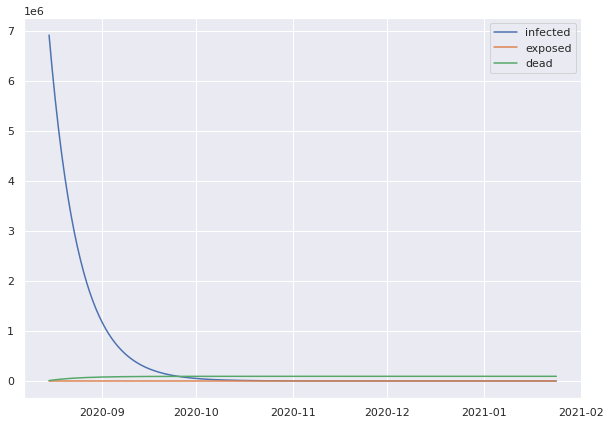

In [165]:
plt.figure(figsize=(10, 7))
plt.plot(subset.date, I, label='infected')
plt.plot(subset.date, E, label='exposed')
#plt.plot(subset.date, R, label='recovered')
plt.plot(subset.date, D, label='dead')
plt.legend()
plt.show()

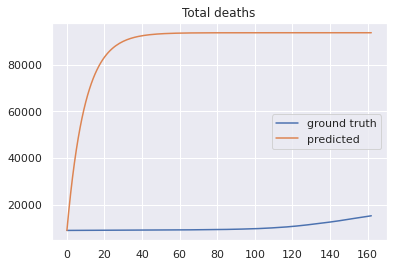

In [166]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['total_dead'], label='ground truth')
plt.plot(x, D, label='predicted')
plt.legend()
plt.title('Total deaths')
plt.show()

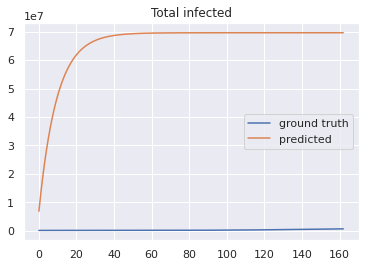

In [167]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['total_infected'], label='ground truth')
plt.plot(x, I.cumsum(), label='predicted')
plt.legend()
plt.title('Total infected')
plt.show()